In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torchvision import models
import pandas as pd
import numpy as np
from torchvision.models import resnet18
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import os
from torch.utils.data import DataLoader
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch import save, load

In [2]:
#Import Dataset for calculating mean and std
dataset = os.path.join('D:/PytorchProjects/resnetpotatoclf/data/')
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = ImageFolder(root = dataset, transform = transform)

print(len(dataset))

# Calculate the mean
mean = torch.zeros(3)
for image, _ in dataset:
    mean += torch.mean(image, dim=(1, 2))

mean /= len(dataset)

# Calculate the standard deviation
variance_sum = torch.zeros(3)
for image, _ in dataset:
    variance_sum += torch.sum((image - mean.unsqueeze(1).unsqueeze(2)) ** 2, dim=(1, 2))

std = torch.sqrt(variance_sum / (len(dataset) * 224 * 224))

print(mean)
print(std)

2152
tensor([0.4983, 0.5114, 0.4322])
tensor([0.2193, 0.2037, 0.2456])


In [3]:
#transform the data
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    
    transforms.Normalize([0.4983, 0.5114, 0.4322], [0.2193, 0.2037, 0.2456])
    
    
])

In [4]:
#Import the Data 
traindata = os.path.join('D:/PytorchProjects/resnetpotatoclf/data/train/')
testdata = os.path.join('D:/PytorchProjects/resnetpotatoclf/data/test/')
valdata = os.path.join('D:/PytorchProjects/resnetpotatoclf/data/val/')

print(len(traindata))
print(len(testdata))
print(len(valdata))


46
45
44


In [5]:
train_data = ImageFolder(traindata,transform=transform)
test_data = ImageFolder(testdata, transform=transform)
val_data =  ImageFolder(valdata, transform=transform)

print("Lenght Of Dataset")
print(len(train_data))
print(len(test_data))
print(len(val_data))
len_train = len(train_data)
len_test = len(test_data)

print("Claases Of Dataset")



print(train_data.classes)
print(test_data.classes)
print(val_data.classes)

Lenght Of Dataset
1721
216
215
Claases Of Dataset
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [6]:
#Check Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
#Index Maping
print(train_data.class_to_idx)

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}


In [8]:
BATCH_SIZE = 64
NUM_EPOCH = 5

In [9]:
train_loader = DataLoader(train_data,batch_size = BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle=True)

print(train_loader)
print(test_loader)

In [10]:
image, label = train_data[0]
image, label

(tensor([[[-2.2722, -2.2722, -2.2722,  ..., -2.2722, -2.2722, -2.2722],
          [-2.2722, -2.2722, -2.2722,  ..., -2.2722, -2.2722, -2.2722],
          [-2.2722, -2.2722, -2.2722,  ..., -2.2722, -2.2722, -2.2722],
          ...,
          [-2.2722, -2.2722, -2.2722,  ..., -2.2722, -2.2722, -2.2722],
          [-2.2722, -2.2722, -2.2722,  ..., -2.2722, -2.2722, -2.2722],
          [-2.2722, -2.2722, -2.2722,  ..., -2.2722, -2.2722, -2.2722]],
 
         [[-2.5106, -2.5106, -2.5106,  ..., -2.5106, -2.5106, -2.5106],
          [-2.5106, -2.5106, -2.5106,  ..., -2.5106, -2.5106, -2.5106],
          [-2.5106, -2.5106, -2.5106,  ..., -2.5106, -2.5106, -2.5106],
          ...,
          [-2.5106, -2.5106, -2.5106,  ..., -2.5106, -2.5106, -2.5106],
          [-2.5106, -2.5106, -2.5106,  ..., -2.5106, -2.5106, -2.5106],
          [-2.5106, -2.5106, -2.5106,  ..., -2.5106, -2.5106, -2.5106]],
 
         [[-1.7598, -1.7598, -1.7598,  ..., -1.7598, -1.7598, -1.7598],
          [-1.7598, -1.7598,

In [11]:
#Image Plot
def imshow(img):
    img = image / 2 + 0.5      # unormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


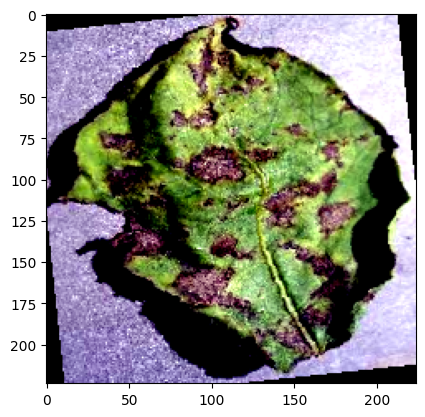

In [12]:
imshow(torchvision.utils.make_grid(image))

In [13]:
#Build Model , Optimizer and Loss Function
model = resnet18(pretrained=True)
num_classes = 3
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, num_classes)
model = model.to(device)
print(model)

d:\PytorchProjects\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\PytorchProjects\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
#Optimizer
optimizer = Adam(model.parameters(),lr=3e-4,weight_decay=0.0001)

#Loss Function
loss_fn = CrossEntropyLoss()

In [15]:
# for epoch in range (1):
#     with tqdm(train_loader, unit="batch") as tepoch:
#         for xtrain, ytrain in tepoch:
#             # Check the range of ytrain
#             unique_labels_train = torch.unique(ytrain)
#             min_label_train = torch.min(unique_labels_train).item()
#             max_label_train = torch.max(unique_labels_train).item()
#             print(f"ytrain: Min label = {min_label_train}, Max label = {max_label_train}")
        
        
#     with torch.no_grad():
#         for xtest, ytest in test_loader:

#             # Check the range of ytest
#             unique_labels_test = torch.unique(ytest)
#             min_label_test = torch.min(unique_labels_test).item()
#             max_label_test = torch.max(unique_labels_test).item()
#             print(f"ytest: Min label = {min_label_test}, Max label = {max_label_test}")

In [15]:
#Train The Model & Evaluate
for epoch in range(5):
    start = time()
    
    traning_acc = 0
    test_acc =0
    
    #Train
    model.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            
            optimizer.zero_grad()
            
            xtrain = xtrain.to(device)
            
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimizer.step()
            
            #training ends
            
            train_pred = torch.max(train_prob, 1).indices
            traning_acc += int(torch.sum(train_pred == ytrain))
            
        epoch_tr_acc = traning_acc / len_train
    
    
    #evaluate Model
    model.eval()
    
    with torch.no_grad():
        for xtest, ytest in test_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_pred = torch.max(test_prob, 1).indices
            
            test_acc += int(torch.sum(test_pred == ytest))
            
        epoch_test_acc = test_acc /  len_test
            
    end = time()
    duration = (end - start) / 60
    print(f"Epoch:{epoch}, Time:{duration},Loss:{loss}\nTrain_acc:{epoch_tr_acc}, Test_Acc:{epoch_test_acc}")


100%|██████████| 27/27 [08:02<00:00, 17.87s/batch]


Epoch:0, Time:8.402902781963348,Loss:0.013915854506194592
Train_acc:0.9622312608948286, Test_Acc:0.9907407407407407


100%|██████████| 27/27 [06:46<00:00, 15.07s/batch]


Epoch:1, Time:7.164777727921804,Loss:0.060396190732717514
Train_acc:0.9936083672283557, Test_Acc:0.9629629629629629


100%|██████████| 27/27 [06:48<00:00, 15.14s/batch]


Epoch:2, Time:7.129138139883677,Loss:0.0466742105782032
Train_acc:0.9982568274259151, Test_Acc:0.9953703703703703


100%|██████████| 27/27 [06:12<00:00, 13.78s/batch]


Epoch:3, Time:6.49808897972107,Loss:0.0009743301197886467
Train_acc:0.9976757699012202, Test_Acc:1.0


100%|██████████| 27/27 [06:06<00:00, 13.57s/batch]


Epoch:4, Time:6.403854330380757,Loss:0.00047797951265238225
Train_acc:0.9982568274259151, Test_Acc:0.9953703703703703


In [16]:
s1 = os.path.join('D:/PytorchProjects/resnetpotatoclf/data/test/Potato___Early_blight/1797b5ac-ed8b-4b35-bd01-f8a14d34d6e1___RS_Early.B 8812.JPG')
s2 = os.path.join('D:/PytorchProjects/resnetpotatoclf/data/test/Potato___Late_blight/0eb24a67-a174-43db-86c7-cca8795942a2___RS_LB 4722.JPG')
s3 = os.path.join('D:/PytorchProjects/resnetpotatoclf/data/test/Potato___healthy/533abd3a-3e1d-42d0-ae9c-5189282b78af___RS_HL 5369.JPG')
s4 = os.path.join('D:/PytorchProjects/resnetpotatoclf/data/test/Potato___Late_blight/b3123a68-bf01-4d71-a561-e1e7363a6419___RS_LB 2586.JPG')
s5 = os.path.join('D:/PytorchProjects/resnetpotatoclf/data/test/Potato___Early_blight/d036af36-99a4-4b25-aa40-2477883e73cf___RS_Early.B 8269.JPG')

sample_list = [s1,s2,s3,s4,s5]

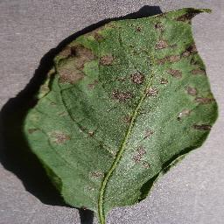

Model Predication 0, Early Blight
-----------------------------------------------


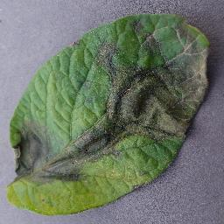

Model Predication 1, Late Blight
-----------------------------------------------


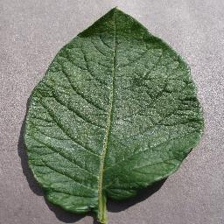

Model Predication 2, Healthy
-----------------------------------------------


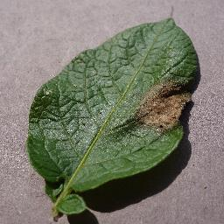

Model Predication 1, Late Blight
-----------------------------------------------


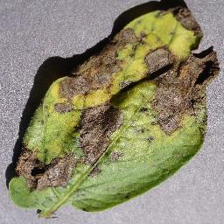

Model Predication 0, Early Blight
-----------------------------------------------


In [17]:
from PIL import Image

for image_path in sample_list:
    
    img = Image.open(image_path)
    display(img.resize((224,224)))
    img_tensor = transform(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    if pred == 0:
        print(f"Model Predication {pred}, Early Blight")
    elif pred == 1:
         print(f"Model Predication {pred}, Late Blight")
    else:
        print(f"Model Predication {pred}, Healthy")

    print("-----------------------------------------------")

In [18]:
torch.save(model.state_dict(), 'resnetpotato.pth')

In [19]:
from PIL import Image

image = Image.open(s1).convert("RGB")
input_tensor = transform(image).unsqueeze(0)
with torch.no_grad():
    output = model(input_tensor)
predicted_index = torch.argmax(output, dim=1).item()
classes = ['Early_blight','Late_blight','Healthy']
predicted_class = classes[predicted_index]

print(predicted_class)    

Early_blight
